In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import matplotlib.pyplot as plt

cudnn.benchmark = True

def visualize_images(dataset, class_names, num_images=9):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3

    for i in range(1, num_images + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item()
        img, label = dataset[sample_idx]
        #label = transform_target(label)
        figure.add_subplot(rows, cols, i)
        plt.title(class_names[label])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))
    plt.show()

def transform_target(target):
    for i in range(len(target)):
        if target[i] in [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]:
            target[i] = torch.tensor([0], device=device)
        else:
            target[i] = torch.tensor([1], device=device)
    
    return target


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                #labels = transform_target(labels)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'train':
                train_losses.append(loss.item())
            else:
                val_losses.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)

    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/plot.png')
    plt.show()

    return model

def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            #labels = transform_target(labels)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            #labels = transform_target(labels).to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += torch.sum(preds == labels.data)
            print(total)

    accuracy = correct.double() / total
    print(f'Test Accuracy: {accuracy:.4f}')
 

Epoch 0/9
----------
train Loss: 3.2862 Acc: 0.1919
val Loss: 2.2090 Acc: 0.7351

Epoch 1/9
----------
train Loss: 2.1904 Acc: 0.5662
val Loss: 1.3359 Acc: 0.8261

Epoch 2/9
----------
train Loss: 1.2196 Acc: 0.7480
val Loss: 0.8085 Acc: 0.8886

Epoch 3/9
----------
train Loss: 0.6760 Acc: 0.8679
val Loss: 0.5302 Acc: 0.8791

Epoch 4/9
----------
train Loss: 0.3940 Acc: 0.9358
val Loss: 0.3916 Acc: 0.9008

Epoch 5/9
----------
train Loss: 0.2505 Acc: 0.9609
val Loss: 0.3048 Acc: 0.9226

Epoch 6/9
----------
train Loss: 0.1719 Acc: 0.9766
val Loss: 0.2915 Acc: 0.9239

Epoch 7/9
----------
train Loss: 0.1140 Acc: 0.9922
val Loss: 0.2685 Acc: 0.9293

Epoch 8/9
----------
train Loss: 0.1112 Acc: 0.9868
val Loss: 0.2284 Acc: 0.9402

Epoch 9/9
----------
train Loss: 0.0984 Acc: 0.9908
val Loss: 0.2376 Acc: 0.9348

Training complete in 6m 41s
Best val Acc: 0.940217


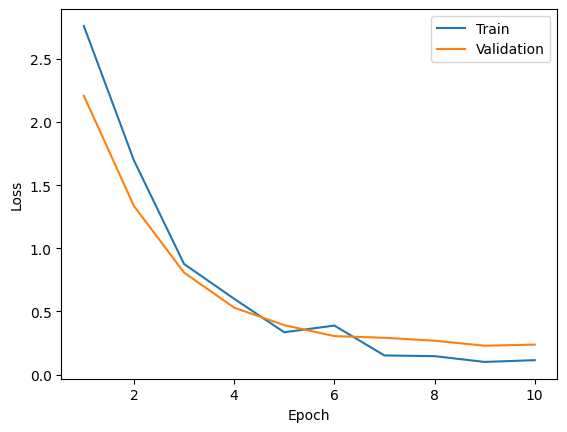

In [44]:
if __name__ == '__main__':
    
# Define the data transformations
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.2)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        #transforms.RandomCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        #transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example different normalization
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])   

    # Load the datasets
    trainvalset = torchvision.datasets.OxfordIIITPet('/content', split='trainval', transform=train_transform, download=True)
    testset = torchvision.datasets.OxfordIIITPet('/content', split='test', transform=test_transform, download=True)

    # Define the split ratio for validation
    val_ratio = 0.2

    # Calculate the sizes of the training and validation subsets
    total_size = len(trainvalset)
    val_size = int(val_ratio * total_size)
    train_size = total_size - val_size

    # Split the trainvalset into training and validation subsets
    trainset, valset = torch.utils.data.random_split(trainvalset, [train_size, val_size])

    # Apply the respective transforms to each subset
    trainset.dataset.transform = train_transform
    #trainset.dataset.target_transform = transform_target
    valset.dataset.transform = val_transform
    #valset.dataset.target_transform = transform_target

    # Create data loaders for training and validation
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=150, shuffle=True, num_workers=2, pin_memory=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=150, shuffle=False, num_workers=2, pin_memory=True)
    
    dataloaders = {'train': trainloader, 'val': valloader}
    dataset_sizes = {'train': len(trainset), 'val': len(valset)}

    #class_names = ['cat', 'dog']
    class_names = trainset.dataset.classes

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the ResNet model with pre-trained weights
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.8),
        nn.Linear(512, len(class_names))
    )

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    
    learning_rates = [0.0001, 0.0001]

    parameter_groups = [
        {'params': model.layer3.parameters(), 'lr': learning_rates[0]},
        {'params': model.layer4.parameters(), 'lr': learning_rates[0]},
        {'params': model.fc.parameters(), 'lr': learning_rates[1]}
    ]

    optimizer = optim.Adam(parameter_groups)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)
    

In [ ]:
    
    # Define the data transformations for training and validation sets
    train_transform = transforms.Compose([
         transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.2)),
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.RandomCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example different normalization
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])   

    # Apply the respective transforms to each subset
    trainset.dataset.transform = train_transform
    #trainset.dataset.target_transform = transform_target
    valset.dataset.transform = val_transform
    #valset.dataset.target_transform = transform_target

    # Create data loaders for training and validation
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=75, shuffle=True, num_workers=2, pin_memory=True)
    valloader = torch.utils.data.DataLoader(valset, batch_size=75, shuffle=False, num_workers=2, pin_memory=True)
    
    dataloaders = {'train': trainloader, 'val': valloader}

    criterion = nn.CrossEntropyLoss()

    learning_rates = [0.0001]

    parameter_groups = [
        {'params': model.fc.parameters(), 'lr': learning_rates[0]}
    ]

    optimizer = optim.Adam(parameter_groups, weight_decay=0.3)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    model = train_model(model, criterion, optimizer, scheduler, num_epochs=7)
    

In [ ]:
visualize_model(model, dataloaders, class_names, num_images=8)

testloader = torch.utils.data.DataLoader(testset, batch_size=300, shuffle=False, num_workers=2, pin_memory=True)
test_model(model, testloader)